**Tutorial 5 - Linear Regession on Galaxy Spectra with Templates**

In this tutorial we will learn how to read data fro a fits file, fit a spectrum to a series of templates and determine the spectrographic redshift of a galaxy.

When assigning redshifts to galaxies with a full observed spectrum, one typically fits model spectra for the rest-frame galaxy spectrum to the observed one while accounting for the redshift of the wavelengths. In this challenge, we first want to try to fit a local spectrum with templates using a linear regression and least-squares before trying to estimate the redshift of a redshifted spectrum.

1) Extract templates spectra from the fits file k_nmf_derived.newdefault.fits.  astropy.io.fits.open() for this.  The function returns a hdul object.  You can look at the contents with hdul.info().  The templates we want are in the second table - templates[1].data - and the corresponding wavelengths are in the templates[11].data.  The other tables contain templates with and without smoothing, dust, lines, etc.  You can look at them if you wish. Print the header information for the for the second table.

In [2]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt

templates = fits.open('k_nmf_derived.newdefault.fits')
templates.info()
print templates[1].header
M = templates[1].data
lam = templates[11].data

print np.shape(M)

Filename: k_nmf_derived.newdefault.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (485, 5)   float32   
  1                1 ImageHDU         7   (27330, 5)   float32   
  2                1 ImageHDU         7   (27330, 5)   float32   
  3                1 ImageHDU         7   (27330, 5)   float32   
  4                1 ImageHDU         7   (27330, 5)   float32   
  5                1 ImageHDU         7   (27330, 5)   float32   
  6                1 ImageHDU         7   (27330, 5)   float32   
  7                1 ImageHDU         7   (27330, 5)   float32   
  8                1 ImageHDU         7   (27330, 5)   float32   
  9                1 ImageHDU         7   (27330, 5)   float32   
 10                1 ImageHDU         7   (10000, 5)   float32   
 11                1 ImageHDU         6   (27330,)   float32   
 12                1 ImageHDU         7   (25, 5)   float32   
 13                1 ImageHDU         7   (25, 

2) Plot the template spectra with proper axis labels and scaling to make it clear.

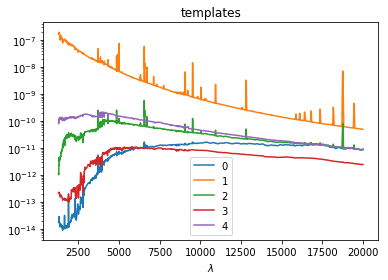

In [46]:
Ntemplates = np.shape(M)[0]
for i in range(Ntemplates) :
    plt.plot(lam,M[i,:],label=str(i))
# or
#plt.plot(lam,M.T)

plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.title('templates')
plt.legend()
plt.show()



Fitting templates to a spectrum.

The linear model for the spectrum is of the form
\begin{equation}
f_\lambda = \sum_i T_\lambda^i \theta^i
\end{equation}
where the $i$th template is $T_\lambda$.  This can be written in matrix notation as
\begin{equation}
\pmb{f} = \pmb{M}\pmb{\theta}
\end{equation}


Formulate and solve the least squares problem of finding the best fit amplitudes of the templates from challenge 1 when fitting them to the data of a local (i.e. redshift zero) spectrum in `localspectrum.txt`. Implement your own linear least squares solver and compare it to `numpy`'s implementation. Which one fits the data better?

3) Load a spectrum from file localspectrum.txt (np.loadtxt()) and plot it.

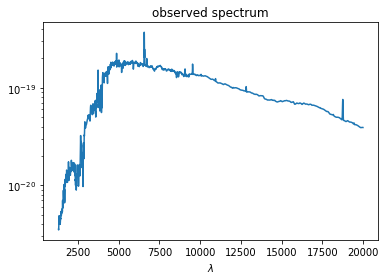

In [5]:
y = np.loadtxt('localspectrum.txt')
plt.plot(lam,y)
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.title('observed spectrum')
plt.show()

4) Find the least-squares solution for the template coefficients.

We could solve this problem using the pseudo-inverse given in equation 6.43 of the lecture notes.  However, inverting the $\pmb{M}^T\pmb{M}$ matrix is very slow because it is so big.  Instead use the numpy.linalg.lstsq() function to find the solution.  Print out separately the least square solution for the coefficients and store them in an array called params.  Which template galaxy is this closest to?

In [16]:
res = np.linalg.lstsq(M.T, y,rcond=None)
#print res
params = res[0]
print params

[5.17619432e-12 2.91919488e-27 3.90618989e-10 1.43607033e-08
 1.34847495e-17]


5) Plot the data again and the model spectrum on top.

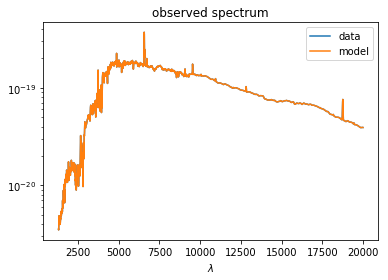

In [21]:
model = np.dot(M.T,params)
plt.plot(lam,y,label='data')
plt.plot(lam,model,label='model')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.title('observed spectrum')
plt.legend()
plt.show()


6) Plot the fractional residuals, (model-data)/data.

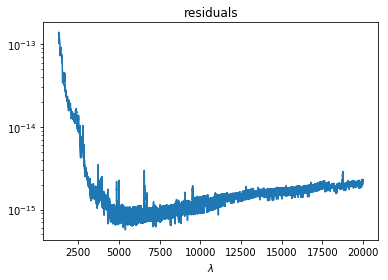

In [22]:

plt.plot(lam,np.abs(model-y)/y)
plt.xlabel(r'$\lambda$')
plt.title('residuals')
plt.yscale('log')
plt.show()

**Fitting for the redshift**

7) Upload the data `redshiftedspectrum.txt`.  It contains a redshifted spectrum. 

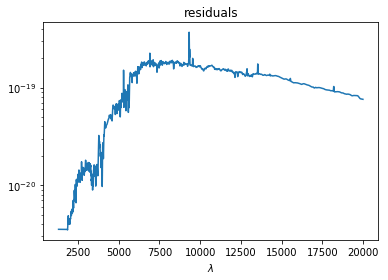

In [23]:
yr = np.loadtxt('redshiftedspectrum.txt')

plt.plot(lam,yr)
plt.xlabel(r'$\lambda$')
plt.title('residuals')
plt.yscale('log')
plt.show()


8) Fitting both redshift and template amplitudes is no longer a linear problem. The observed wavelength $\lambda_o$ is related to the restframe wavelength $\lambda$ by
\begin{equation}
\lambda = \frac{\lambda_o }{ (1+z)}
\end{equation}

Implement the following steps:

Make an array of 1000 redshifts evenly spaced between 0 to 1.

Loop through the redshifts

    find restframe wavelengths of the observed wavelengths

    find which wavelengths fall within the range of the template
    inds = np.where(lambda < lambda_rest[-1])
 
    use the numpy.interp() function to interpolate 
       the observed spectrum to the resframe wavelengths of 
       the templates.
        yinterp = np.interp(lambda[inds], lambda_rest, data)
    
    use np.linalg.lstsq() to find the coefficients
       (make sure you only use observed wavelengths)
   
    save the residual for each redshift
    
Plot the residuals as a function of redshift.
What is the best redshift? (np.argmin())

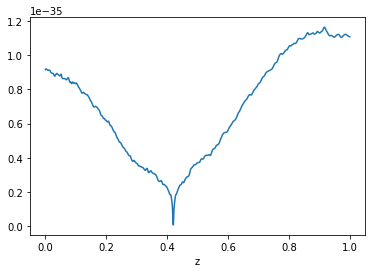

z=  0.42042042042042044


In [38]:
z = np.linspace(0, 1, 1000)
results = np.zeros((len(z),5))
resids = np.zeros(len(z))
min_res = -1
for i in range(z.shape[0]):
    lam_loc = lam / (1. + z[i])
    inds = np.where(lam < lam_loc[-1])#[0]
    yinterp = np.interp(lam[inds], lam_loc, yr)
    res = np.linalg.lstsq(M.T[inds], yinterp[inds],rcond=None)
    resids[i] = res[1]
    results[i] = res[0]

ibest = np.argmin(resids)
plt.plot(z, resids)
plt.xlabel('z')
plt.show()

print 'z= ',z[ibest]

9) Plot the model spectrum and data with respect to observed wavelength.

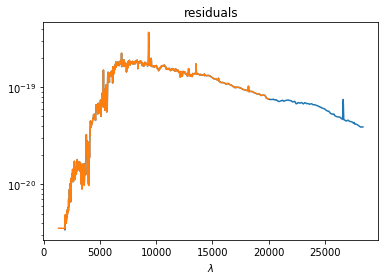

In [43]:
model = np.dot(M.T,results[ibest])
ll = lam*(1+z[ibest])

plt.plot(ll,model)
plt.plot(lam,yr)
plt.xlabel(r'$\lambda$')
plt.title('residuals')
plt.yscale('log')
plt.show()

